In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = """
SELECT * FROM echo_filtered
"""
ef = pd.read_sql_query(query, con)
ef.head()

,row_id,icustay_id,hadm_id,subject_id,age_at_intime,gender,height,weight,bmi,ethnicity,...,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,most_recent_hadm,first_echo
0,67805,280987,182104,36,25443 days 10:29:14,M,NaN,NaN,NaN,WHITE,...,1885.0,1116.0,508.0,1201.0,-693.0,NaN,NaN,NaN,1,1
1,67118,216609,116009,62,25097 days 00:20:44,M,68.0,150.0,22.804931,PATIENT DECLINED TO ANSWER,...,698.0,2083.0,505.0,1525.0,-1020.0,335.5,730.0,-394.5,1,1
2,80320,281607,112086,75,28018 days 10:35:50,F,NaN,NaN,NaN,WHITE,...,1410.0,1630.0,12.0,1475.0,-1463.0,NaN,NaN,NaN,1,1
3,80083,206222,190243,86,16521 days 11:51:54,F,NaN,NaN,NaN,WHITE,...,1707.0,1813.0,1006.0,1430.0,-424.0,NaN,NaN,NaN,1,1
4,82745,232514,114585,115,27643 days 13:22:28,F,63.0,207.0,36.664399,WHITE,...,1229.0,2255.0,1105.5,1466.0,-360.5,NaN,NaN,NaN,1,1


In [5]:
len(ef)

2094

In [6]:
day30_mortality = ef.ea_days_after_discharge_death <= 30

In [7]:
day30_mortality.value_counts()

False    1861
True      233
Name: ea_days_after_discharge_death, dtype: int64

In [8]:
ef['day30_mortality'] = day30_mortality

In [9]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age_at_intime/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [10]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    890
1    679
2    221
3    129
4    128
5     47
dtype: int64

In [11]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    1569
1     350
2     175
dtype: int64

In [12]:
model_data = ef[['ea_lv_systolic', 'ex_congestive_heart_failure'
                , 'mech_vent', 'mdrd', 'mdrd_discrete', 'mdrd_3', 'apsiii'
                , 'fl_day1_balance_ml', 'day30_mortality']].copy()
age = ef.age_at_intime/np.timedelta64('1', 'Y')
age.loc[age<0] = age.max()
model_data['age'] = age
model_data.loc[model_data.ea_lv_systolic == -50] = np.nan
model_data = model_data.dropna()
## normalize the continuous variables
for var in ['apsiii', 'age', 'fl_day1_balance_ml', 'mdrd']:
    mu = model_data[var].mean()
    std = model_data[var].std()
    model_data[var] = (model_data[var]-mu)/std
model_data['ea_lv_systolic'] = model_data.ea_lv_systolic.astype(int) + 2
model_data['ex_congestive_heart_failure'] = model_data.ex_congestive_heart_failure.astype(int)
model_data['mech_vent'] = model_data.mech_vent.astype(int)
model_data['day30_mortality'] = model_data.day30_mortality.astype(int)
model_data['mdrd_discrete'] = model_data.mdrd_discrete.astype(int) + 1
model_data['mdrd_3'] = model_data.mdrd_3.astype(int) + 1
print(len(model_data))
model_data.head()

1716


,ea_lv_systolic,ex_congestive_heart_failure,mech_vent,mdrd,mdrd_discrete,mdrd_3,apsiii,fl_day1_balance_ml,day30_mortality,age
0,3,0,0,0.611369,1,1,-1.139052,-0.213759,0,0.405750
1,2,0,0,0.618537,1,1,0.000812,0.171099,0,0.336295
2,2,0,1,0.798723,1,1,-0.759098,-0.009192,0,0.922015
3,2,0,0,0.528223,1,1,-0.801315,0.063641,0,-1.383021
4,1,1,1,-1.286615,5,3,0.802939,0.239553,0,0.846854


### Model using continuous MDRD

In [21]:
data = {'N': len(model_data)
       , 'ea_lv_systolic': model_data.ea_lv_systolic
       , 'ex_congestive_heart_failure': model_data.ex_congestive_heart_failure
       , 'mech_vent': model_data.mech_vent
       , 'mdrd': model_data.mdrd
       , 'apsiii': model_data.apsiii
       , 'age': model_data.age
       , 'fluid_day1_balance': model_data.fl_day1_balance_ml
       , 'y': model_data.day30_mortality
       }

In [17]:
%%writefile 170117_model_linear_TB.stan

data{
    int<lower=0> N;
    
    int<lower=1, upper=5> ea_lv_systolic[N];
    vector[N] ex_congestive_heart_failure;
    vector[N] mech_vent;
    vector[N] mdrd;
    vector[N] apsiii;
    vector[N] age;
    vector[N] fluid_day1_balance;
    
    int<lower=0, upper=1> y[N];
}

parameters{
    real bias;
    
    vector[5] beta_ea_lv_systolic;
    real beta_ex_congestive_heart_failure;
    real beta_mech_vent;
    real beta_mdrd;
    real beta_apsiii;
    real beta_age;
    real beta_fluid;
    
    vector[5] gamma_ea_lv_systolic;
    real gamma_ex_congestive_heart_failure;
    real gamma_mech_vent;
    real gamma_mdrd;
    
    vector[5] gamma_lv_sys_by_chf;
    vector[5] gamma_lv_sys_by_mdrd;
    
}

transformed parameters {
    vector[N] y_hat;
    vector[N] beta;
    vector[N] gamma;
    
    beta = bias + beta_ea_lv_systolic[ea_lv_systolic]
        + beta_ex_congestive_heart_failure*ex_congestive_heart_failure
        + beta_mech_vent*mech_vent
        + beta_mdrd*mdrd
        + beta_apsiii*apsiii
        + beta_age*age;
    
    gamma = beta_fluid + gamma_ea_lv_systolic[ea_lv_systolic]
        + gamma_ex_congestive_heart_failure*ex_congestive_heart_failure
        + gamma_mech_vent*mech_vent
        + gamma_mdrd*mdrd
        + gamma_lv_sys_by_chf[ea_lv_systolic] .* ex_congestive_heart_failure
        + gamma_lv_sys_by_mdrd[ea_lv_systolic] .* mdrd;
    
    y_hat = beta + gamma .* fluid_day1_balance;
}

model {
    beta_ea_lv_systolic ~ normal(0,1);
    beta_ex_congestive_heart_failure ~ normal(0,1);
    beta_mech_vent ~ normal(0,1);
    beta_mdrd ~ normal(0,1);
    beta_apsiii ~ normal(0,1);
    beta_age ~ normal(0,1);
    
    beta_fluid ~ normal(0,1);
    gamma_ea_lv_systolic ~ normal(0,1);
    gamma_ex_congestive_heart_failure ~ normal(0,1);
    gamma_mech_vent ~ normal(0,1);
    gamma_mdrd ~ normal(0,1);
    gamma_lv_sys_by_chf ~ normal(0,1);
    gamma_lv_sys_by_mdrd ~ normal(0,1);
    
    y ~ bernoulli_logit(y_hat);
}


Overwriting 170117_model_linear_TB.stan


In [34]:
def predict_linear(thetas, xs):
    beta = thetas['bias'] + thetas['beta_ea_lv_systolic'][:,xs.ea_lv_systolic-1].T
    beta += np.outer(xs.ex_congestive_heart_failure, thetas['beta_ex_congestive_heart_failure'])
    beta += np.outer(xs.mech_vent, thetas['beta_mech_vent'])
    beta += np.outer(xs.mdrd, thetas['beta_mdrd'])
    beta += np.outer(xs.apsiii, thetas['beta_apsiii'])
    beta += np.outer(xs.age, thetas['beta_age'])
    
    gamma = thetas['beta_fluid'] + thetas['gamma_ea_lv_systolic'][:,xs.ea_lv_systolic-1].T
    gamma += np.outer(xs.ex_congestive_heart_failure, thetas['gamma_ex_congestive_heart_failure'])
    gamma += np.outer(xs.mech_vent, thetas['gamma_mech_vent'])
    gamma += np.outer(xs.mdrd, thetas['gamma_mdrd'])
    gamma += thetas['gamma_lv_sys_by_chf'][:,xs.ea_lv_systolic-1].T * xs.ex_congestive_heart_failure.values[...,np.newaxis]
    gamma += thetas['gamma_lv_sys_by_mdrd'][:,xs.ea_lv_systolic-1].T * xs.mdrd.values[...,np.newaxis]
    
    return beta + gamma*xs.fl_day1_balance_ml.values[...,np.newaxis]


In [18]:
#compile the model
model_linear = pystan.StanModel(file='170117_model_linear_TB.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad5783dcbe3fd6194c76e203866cd702 NOW.


In [22]:
#fit the model
model_fit = model_linear.sampling(data, chains=1, iter=4000, algorithm='NUTS')

In [23]:
model_fit

Inference for Stan model: anon_model_ad5783dcbe3fd6194c76e203866cd702.
1 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=2000.

                                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bias                                -3.2    0.01   0.49  -4.15  -3.52   -3.2  -2.85  -2.28 1048.0    1.0
beta_ea_lv_systolic[0]              0.61    0.02   0.52   -0.4   0.28    0.6   0.95   1.67 1170.0    1.0
beta_ea_lv_systolic[1]             -0.02    0.01   0.48  -0.92  -0.34  -0.01   0.29   0.91 1051.0    1.0
beta_ea_lv_systolic[2]              -0.5    0.02   0.54  -1.57  -0.88   -0.5  -0.15   0.53 1143.0   1.01
beta_ea_lv_systolic[3]             -0.19    0.01   0.57  -1.32  -0.57  -0.19   0.21   0.92 1504.0    1.0
beta_ea_lv_systolic[4]              0.06    0.01   0.58   -1.1  -0.34   0.05   0.44   1.19 1532.0    1.0
beta_ex_congestive_heart_failure    1.21  6.5e-3   0.29   0.64   1.02    1.2

### Take a look at model accuracy

In [24]:
y_hats = model_fit.extract('y_hat')
y_hats = pd.DataFrame(y_hats['y_hat'])
y_hats.head()

,0,1,2,3,4,5,6,7,8,9,...,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715
0,-4.477068,-3.292272,-2.943364,-4.076610,1.156985,-2.422839,-4.191079,-2.341164,-2.972751,0.290896,...,-3.705737,-3.673395,-1.879498,0.037020,-2.912978,-2.018296,-4.291118,-3.029967,-1.987897,-4.179714
1,-4.418856,-3.687102,-3.051571,-4.511047,1.430012,-2.213727,-4.706860,-1.840297,-3.726929,0.145916,...,-4.232373,-3.945272,-1.668131,-3.290885,-2.532048,-2.679521,-4.799477,-2.512428,-1.992501,-4.518557
2,-5.036910,-3.694372,-3.102623,-4.543630,1.151857,-2.426545,-4.804301,-2.156093,-3.365270,0.090090,...,-4.036940,-3.970096,-2.287340,-0.954715,-2.885512,-2.522284,-4.752904,-3.437041,-2.105885,-4.689877
3,-5.318013,-3.497761,-3.246380,-4.386342,1.249071,-2.270486,-4.574533,-2.342642,-3.316419,0.374724,...,-4.123885,-3.938398,-2.020826,0.533540,-2.710800,-1.968010,-4.690201,-3.036062,-1.775474,-4.517671
4,-4.846085,-3.562753,-3.081510,-4.534025,1.004102,-2.107730,-4.853211,-2.065280,-2.998852,-0.739425,...,-3.483117,-3.600387,-3.822118,0.320519,-2.670985,-2.660707,-4.619338,-4.065457,-2.021268,-4.591277


In [25]:
y_hat_mu = y_hats.mean()

In [26]:
y_hat_p = 1./(1+np.exp(-y_hat_mu))

In [27]:
((y_hat_p >= 0.5) == model_data.day30_mortality).mean()

0.90850815850815847

In [28]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

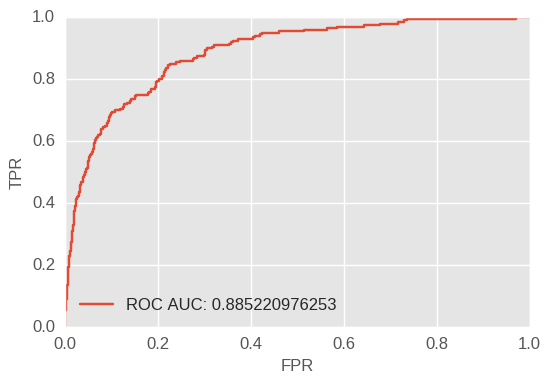

In [29]:
fpr, tpr, _ = roc_curve(model_data.day30_mortality, y_hat_mu)
aucroc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC AUC: {}'.format(aucroc))
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')

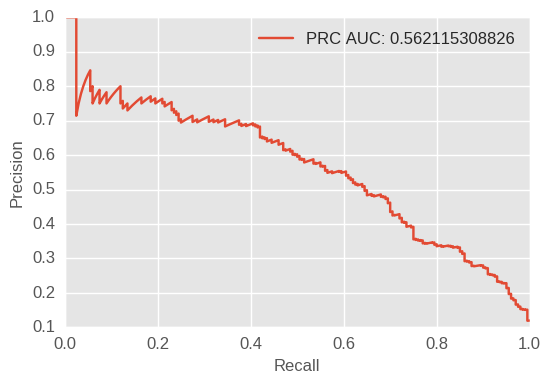

In [30]:
prec, rec, _ = precision_recall_curve(model_data.day30_mortality, y_hat_mu)
aucprc = auc(rec, prec)
plt.plot(rec, prec, label='PRC AUC: {}'.format(aucprc))
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [32]:
def threshold_accuracy(y_true, y_pred):
    I = y_pred.argsort()
    y_true = y_true[I]
    y_pred = y_pred[I]
    tru = np.cumsum(y_true[::-1])[::-1]
    fls = np.cumsum(1-y_true) - 1
    cor = tru+fls
    acc = cor / float(len(y_pred))
    return acc, y_pred, y_true

0.909090909091 -0.275552187446


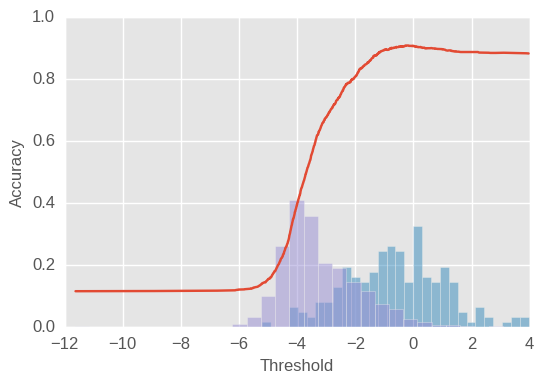

In [33]:
acc, thresh, label = threshold_accuracy(model_data.day30_mortality.values, y_hat_mu.values)
i = np.argmax(acc)
print(acc[i], thresh[i])
plt.plot(thresh, acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.hist(thresh[label==1], normed=True, alpha=0.5, bins=30)
plt.hist(thresh[label==0], normed=True, alpha=0.5, bins=30)
pass

In [191]:
model_data.day30_mortality.mean()

0.11655011655011654

### Plot some prediction vs fluid balance curves

In [36]:
thetas_linear = model_fit.extract(['bias', 'beta_ea_lv_systolic', 'beta_ex_congestive_heart_failure'
                                          , 'beta_mech_vent', 'beta_mdrd', 'beta_apsiii', 'beta_age', 'beta_fluid'
                                          , 'gamma_ea_lv_systolic', 'gamma_ex_congestive_heart_failure'
                                          , 'gamma_mech_vent', 'gamma_mdrd', 'gamma_lv_sys_by_chf'
                                          , 'gamma_lv_sys_by_mdrd'])

In [37]:
flags = ['ex_congestive_heart_failure', 'ea_lv_systolic', 'mech_vent', 'mdrd', 'apsiii', 'age']

def predict_quantiles(fluid_range, df, as_logit=True):
    fluid_df = pd.DataFrame({'fl_day1_balance_ml': fluid_range})
    df = df.copy()
    del df['day30_mortality']
    del df['mdrd_discrete']
    del df['mdrd_3']
    
    q = [2.5, 50., 97.5]
    quants = np.zeros((len(fluid_range), 1+len(q)))
    for i,fl in enumerate(fluid_range):
        df['fl_day1_balance_ml'] = fl
        yh = predict_linear(thetas_linear, df)
        if not as_logit:
            yh = 1./(1. + np.exp(-yh))
        quants[i,0] = np.mean(yh)
        quants[i,1:] = np.percentile(yh, q)
    
    return quants

In [38]:
mi, ma = model_data.fl_day1_balance_ml.min(), model_data.fl_day1_balance_ml.max()
fluid_range = np.linspace(mi, ma, 100)
def df_predict_quantiles(df):
    q = predict_quantiles(fluid_range, df)
    return pd.DataFrame(q)
chf_quantiles = model_data.groupby('ex_congestive_heart_failure').apply(df_predict_quantiles)
chf_quantiles.reset_index(level=0, inplace=True)
chf_quantiles.head()

,ex_congestive_heart_failure,0,1,2,3
0,0,-1.664297,-5.423112,-1.965015,3.326022
1,0,-1.703167,-5.398354,-2.004496,3.217909
2,0,-1.742037,-5.373464,-2.044198,3.113401
3,0,-1.780907,-5.349535,-2.083968,3.011446
4,0,-1.819776,-5.327880,-2.124118,2.910726


In [39]:
def df_predict_quantiles_p(df):
    q = predict_quantiles(fluid_range, df, as_logit=False)
    return pd.DataFrame(q)
chf_p_quantiles = model_data.groupby('ex_congestive_heart_failure').apply(df_predict_quantiles_p)
chf_p_quantiles.reset_index(level=0, inplace=True)
chf_p_quantiles.head()

,ex_congestive_heart_failure,0,1,2,3
0,0,0.251219,0.004394,0.122925,0.965311
1,0,0.245953,0.004504,0.118732,0.961503
2,0,0.240709,0.004617,0.114640,0.957442
3,0,0.235490,0.004728,0.110665,0.953089
4,0,0.230299,0.004831,0.106775,0.948374


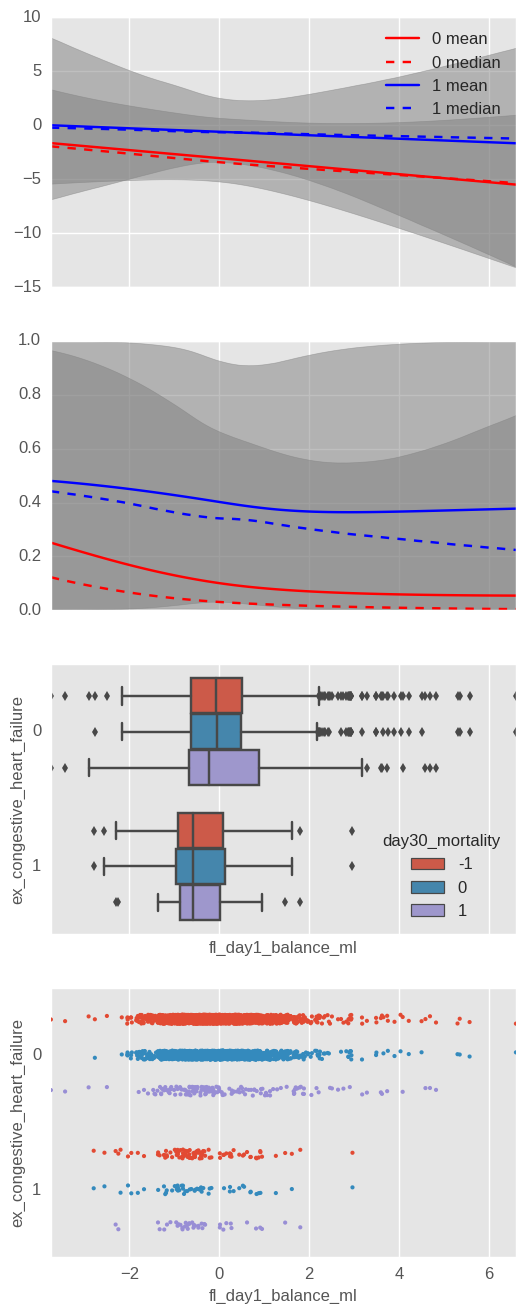

In [40]:
fig, ax = plt.subplots(4, figsize=(6, 16), sharex=True)
color = ['r', 'b']
for flag,df in chf_quantiles.groupby('ex_congestive_heart_failure'):
    quants = df[[0,1,2,3]].values #, as_logit=False)
    mu = quants[:,0]
    lo = quants[:,1]
    med = quants[:,2]
    hi = quants[:,3]
    ax[0].plot(fluid_range, mu, color[flag], label=str(flag) + ' mean')
    ax[0].plot(fluid_range, med, '--'+color[flag], label=str(flag) + ' median')
    ax[0].fill_between(fluid_range, hi, lo, color='gray', alpha=0.5)
    #md_flag = model_data.loc[model_data.ex_congestive_heart_failure == flag]
    #ax[1].hist(md_flag.fl_day1_balance_ml, normed=True, alpha=0.5, bins=20)
    #for f2,mddf in md_flag.groupby('day30_mortality'):
    #    ax[2].hist(mddf.fl_day1_balance_ml, normed=True, bottom=f2, alpha=0.5
    #               , label='CHF: '+str(flag)+', Mortality:'+str(f2))
    #ax[2].plot(md_flag.fl_day1_balance_ml, md_flag.day30_mortality, '.', label=flag)
for flag,df in chf_p_quantiles.groupby('ex_congestive_heart_failure'):
    quants = df[[0,1,2,3]].values #, as_logit=False)
    mu = quants[:,0]
    lo = quants[:,1]
    med = quants[:,2]
    hi = quants[:,3]
    ax[1].plot(fluid_range, mu, color[flag], label=str(flag) + ' mean')
    ax[1].plot(fluid_range, med, '--'+color[flag], label=str(flag) + ' median')
    ax[1].fill_between(fluid_range, hi, lo, color='gray', alpha=0.5)    
ax[0].legend(loc='best')
_ = ax[0].set_xlim((mi, ma))
#_ = ax[0].set_ylim((-6, 20))

to_plot = model_data.copy()
to_plot['day30_mortality'] = -1
to_plot = pd.concat([to_plot, model_data], axis=0)
sns.boxplot(ax=ax[2], data=to_plot, y='ex_congestive_heart_failure', x='fl_day1_balance_ml', hue='day30_mortality'
           , orient='h')
sns.stripplot(ax=ax[3], x='fl_day1_balance_ml', y='ex_congestive_heart_failure', hue='day30_mortality'
              ,data=to_plot, split=True, jitter=True, size=3, linewidth=0, orient='h')
_ = ax[3].legend().set_visible(False)

### Take a look at the posteriors of some of the parameters

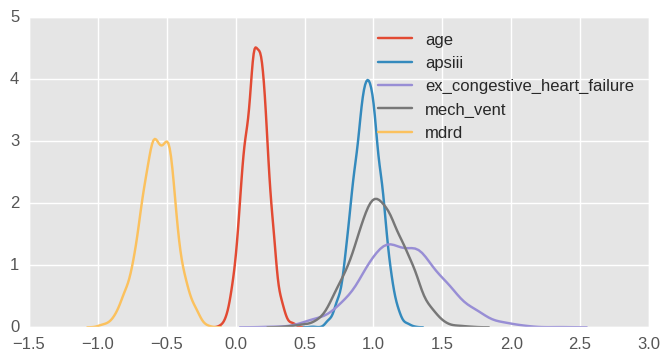

In [41]:
factors = model_fit.extract(['beta_age', 'beta_apsiii', 'beta_ex_congestive_heart_failure', 'beta_mech_vent'
                            , 'beta_mdrd'])
plt.figure(figsize=(8, 4))
for key in ['age', 'apsiii', 'ex_congestive_heart_failure', 'mech_vent', 'mdrd']:
    sns.kdeplot(factors['beta_'+key], label=key)
plt.legend(loc='best')

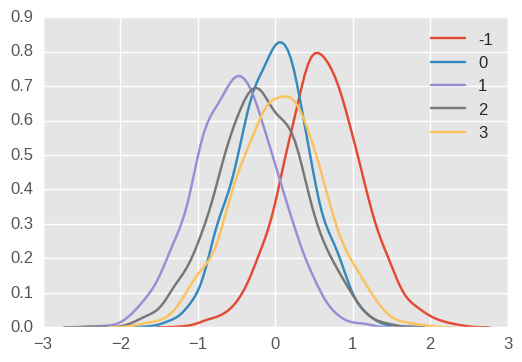

In [42]:
beta_lv_sys = model_fit.extract('beta_ea_lv_systolic')['beta_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(beta_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

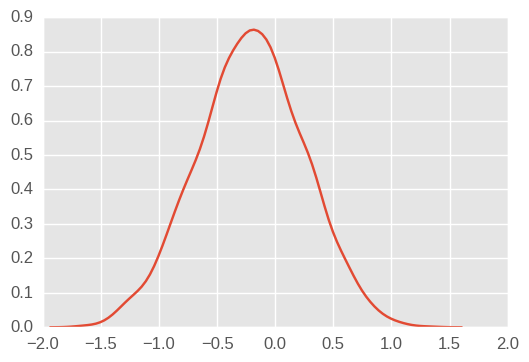

In [43]:
sns.kdeplot(model_fit.extract('beta_fluid')['beta_fluid'])

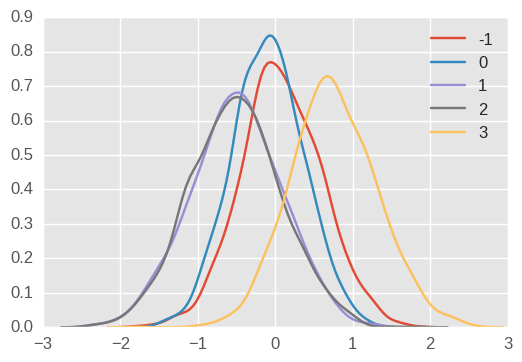

In [44]:
gamma_lv_sys = model_fit.extract('gamma_ea_lv_systolic')['gamma_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(gamma_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

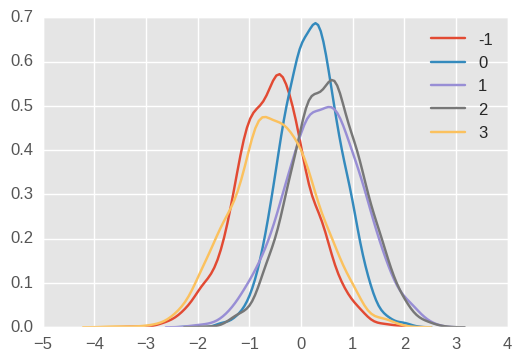

In [45]:
gamma_lv_sys_by_chf = model_fit.extract('gamma_lv_sys_by_chf')['gamma_lv_sys_by_chf']
for i in range(5):
    sns.kdeplot(gamma_lv_sys_by_chf[:,i], label=str(i-1))
plt.legend(loc='best')

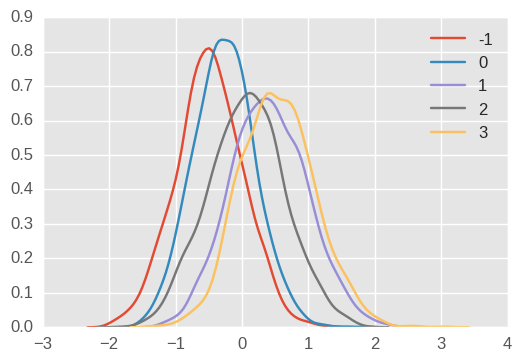

In [46]:
gamma_lv_sys_by_mdrd = model_fit.extract('gamma_lv_sys_by_mdrd')['gamma_lv_sys_by_mdrd']
for i in range(5):
    sns.kdeplot(gamma_lv_sys_by_mdrd[:,i], label=str(i-1))
plt.legend(loc='best')